# Exploring Titan with Spectral Analysis

(description)


## 1. Import Libraries

**Numpy**: Managing multi-dimensional arrays and curve fitting. [Numpy Documentation](https://numpy.org/doc/)  
**Matplotlib**: Creating and displaying plots. [Matplotlib Documentation](https://matplotlib.org/3.3.3/contents.html)  
**Pysis**: Reading .cub files into array format. [Pysis Documentation](https://pysis.readthedocs.io/en/latest/)     
**os**: Navigating and viewing directories. [os Documentation](https://docs.python.org/3/library/os.html)  
**SciPy** Fitting Gaussian functions and power laws to data. [SciPy Documentation](https://www.scipy.org/docs.html)


In [35]:
from IPython.core.display import HTML
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pylab import *
import pysis
import os
import scipy.optimize as sco
%matplotlib qt

In [36]:
#Navigation information
'''
0: Number of Counts
1: Phase *
2: Emission * 
3: Incidence  *
4: Local Emission  
5: Local Incidence  
6: Latitude
7: Longitude  
8: Pixel Resolution  
9: Line Resolution  
10: Sample Resolution  
11: Detector Resolution  
12: North Azimuth
13: Sun Azimuth  
14: Spacecraft Azmituh  
15: Off Nadir Angle
16: Subspacecraft Ground Azimuth  
17: Subsolar Ground Azimuth
18: Morphology = Pixel Resolution/cos(Emission Angle)
19: Albedo = PixelResolution * [(1 / cos(EmissionAngle)) + (1 / cos(IncidenceAngle))]
20: Right Ascension
21: Declination
22: Body Fixed Coordinate X
23: Body Fixed Coordinate Y
24: Body Fixed Coordinate Z
'''

vims_wave = np.loadtxt('/home/alanyu/Dropbox (MIT)/VIMS_UROP/vims_wave.txt') 

In [37]:
def constant_value_nav(nav, nav_number,value):
    """
    Given navigation data, an index into nav measurements, and a value, returns a set of all (i,j) with that value in nav. 
    """
    constants = []
    for i in range(64):
        for j in range(64):
           # print(i)
            if round(nav[nav_number,i,j]) == value:
                #print(i)
                constants.append((i,j))
            else:
                continue
                
    return constants

In [38]:
def gaussian(x,mean,sigma,A):
    
    return A*np.exp( -((x-mean)**2.) / (2.*sigma**2.) )

def powerlaw(x,a, k, c):
    
    return a*x**k + c


In [39]:
def create_gaussian_array(cube,nav,x,y):
    """
    Given cube data (cube) and navigation information (nav), adjusts data by subtracting fitted powerlaw and returns x by y arrays of:
    
    1) Gaussian means
    2) Gaussian widths
    3) Gaussian amplitudes
    
    4) Powerlaw amplitudes
    5) Powerlaw exponent
    6) Powerlaw constant
    
    """
    
    band_channels = [29,30,31,32,47,48,49,50,51,52,53,54,55,84,85,86,87,88,89,90] + [i for i in range(160,181)] 
    
    means = np.zeros((x,y))
    sigmas = np.zeros((x,y))
    amps = np.zeros((x,y))
    plaw = np.zeros((x,y))
    plaw2 = np.zeros((x,y))
    plaw3 = np.zeros((x,y))
    
    for i in range(x):
        for j in range(y):
            if nav[6,i,j] < -90:
                continue
            else:
                try:
                    #Fit power law
                    p_fit, p_cov = sco.curve_fit(powerlaw, vims_wave[band_channels], cube[band_channels, i,j], p0 = (.005,-2,0), maxfev = 10000)
                    p = powerlaw(vims_wave, *p_fit)
                    
                    #Subtract power law
                    new_data = cube[:,i,j] - p

                    #Fit gaussian
                    fit,cov = sco.curve_fit(gaussian, vims_wave[64:85],new_data[64:85], \
                                        p0=(2.08,.125,.1), maxfev=100000)

                    plaw[i,j] = p_fit[0]
                    plaw2[i,j] = p_fit[1]
                    plaw3[i,j] = p_fit[2]
                    
                except:
                    #If powerlaw fit fails, directly fit gaussian
                    fit,cov = sco.curve_fit(gaussian, vims_wave[64:85],cube[64:85,i,j], p0=(2.08,.125,.1), maxfev=10000)
                    
                    
                means[i,j] = fit[0]
                sigmas[i,j] = fit[1]
                amps[i,j] = fit[2]

    return (means,sigmas,amps,plaw,plaw2,plaw3)

In [40]:
def create_panels(data, nav,x,y,cb=[(0,.2),(0,.2),(2.02,2.04),(27,30),(0,80),(0,100),(0,0.1),(-3,-2)]):  
    """
    Given cube data and navigation information, creates 9 panels summarizing variation of different variables. Cb is a list of tuples representing 
    min and max values of the colorbar for each variable.
    
    1) Gaussian Amplitudes
    2) Gaussian Width
    3) Gaussian Mean
    
    4) Navigation Phase
    5) Navigation Emission
    6) Navigation Incidence
    
    7) Powerlaw Amplitude
    8) Powerlaw Exponent
    
    9) Channel 69 
    """
    array = create_gaussian_array(data,nav,x,y)
    A = array[2]
    W = array[1]
    M = array[0]
    plaw_amp = array[3]
    plaw_power = array[4]
    plaw_constant = array[5]
    #Subplots
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(331)
    ax2 = f.add_subplot(332)
    ax3 = f.add_subplot(333)
    ax4 = f.add_subplot(334)
    ax5 = f.add_subplot(335)
    ax6 = f.add_subplot(336)
    ax7 = f.add_subplot(337)
    ax8 = f.add_subplot(338)
    ax9 = f.add_subplot(339)

    #GAUSSIAN
    ax.title.set_text("Gaussian - Amplitudes")
    amps = ax.imshow(A,vmin=cb[0][0],vmax=cb[0][1])
    plt.colorbar(amps,ax=ax)

    ax2.title.set_text("Gaussian - Width")
    width = ax2.imshow(W, vmin = cb[1][0], vmax=cb[1][1])
    plt.colorbar(width,ax=ax2)

    ax3.title.set_text("Gaussian - Mean")
    mean = ax3.imshow(M, vmin=cb[2][0],vmax=cb[2][1])
    plt.colorbar(mean,ax=ax3)

    #NAVIGATION
    ax4.title.set_text("Navigation - Phase")
    phase = ax4.imshow(nav[1,:,:], vmin=cb[3][0],vmax=cb[3][1])
    plt.colorbar(phase, ax=ax4)

    ax5.title.set_text("Navigation - Emission")
    emission = ax5.imshow(nav[2,:,:], vmin=cb[4][0], vmax=cb[4][1])
    plt.colorbar(emission,ax = ax5)

    ax6.title.set_text("Navigation - Incidence")
    incidence = ax6.imshow(nav[3,:,:], vmin = cb[5][0], vmax=cb[5][1])
    plt.colorbar(incidence,ax=ax6)

    ax7.title.set_text("Powerlaw - Amplitude")
    plaw = ax7.imshow(plaw_amp, vmin = cb[6][0], vmax=cb[6][1])
    plt.colorbar(plaw,ax=ax7)

    ax8.title.set_text("Powerlaw - Exponent")
    plaw2 = ax8.imshow(plaw_power, vmin=cb[7][0],vmax=cb[7][1])
    plt.colorbar(plaw2,ax=ax8)

    ax9.title.set_text("Channel 69")
    channel = ax9.imshow(data[69,:,:])
    plt.colorbar(channel,ax=ax9)
    #return array

In [10]:
%matplotlib qt
colorbar = [(0,.2),(0,.2),(2.02,2.04),(27,30),(0,80),(0,100),(0,0.1),(-3,-2)]

data = pysis.CubeFile('/home/alanyu/Dropbox (MIT)/VIMS_UROP/2005359T100445_2005360T101919/CM_1514281143_1_ir.cub').data
lbl = pysis.CubeFile('/home/alanyu/Dropbox (MIT)/VIMS_UROP/2005359T100445_2005360T101919/CM_1514281143_1_ir.cub').label
nav = pysis.CubeFile('/home/alanyu/Dropbox (MIT)/VIMS_UROP/2005359T100445_2005360T101919/CM_1514281143_1_ir_nav.cub').data

create_panels(data,nav,64,64,colorbar)

In [24]:
#Viewing geometry - 2009189T194600_2009189T235739
colorbar_2009 = [(0,0.05),(0.07,0.09),(2.02,2.04),(28.1,28.3),(50,90),(85,110),(0.01,0.03),(-1.5,-3)]


data8 = pysis.CubeFile('/home/alanyu/Dropbox (MIT)/VIMS_UROP/2009189T194600_2009189T235739/CM_1625778429_1_ir.cub').data
lbl8 = pysis.CubeFile('/home/alanyu/Dropbox (MIT)/VIMS_UROP/2009189T194600_2009189T235739/CM_1625778429_1_ir.cub').label
nav8 = pysis.CubeFile('/home/alanyu/Dropbox (MIT)/VIMS_UROP/2009189T194600_2009189T235739/CM_1625778429_1_ir_nav.cub').data

create_panels(data8,nav8,64,4, colorbar_2009)

In [46]:
#Different viewing geometry - 2016127T223449_2016130T200342
%matplotlib qt

colobar_2016 = [(0,.3),(-0.001,0.2),(2.02,2.05),(120,122),(0,80),(0,130),(-0.05,0.15),(-3,0)]


data7 = pysis.CubeFile('/home/alanyu/Dropbox (MIT)/VIMS_UROP/2016127T223449_2016130T200342/CM_1841269234_1_ir.cub').data
lbl7 = pysis.CubeFile('/home/alanyu/Dropbox (MIT)/VIMS_UROP/2016127T223449_2016130T200342/CM_1841269234_1_ir.cub').label
nav7 = pysis.CubeFile('/home/alanyu/Dropbox (MIT)/VIMS_UROP/2016127T223449_2016130T200342/CM_1841269234_1_ir_nav.cub').data

create_panels(data7, nav7,64,64,colobar_2016)

<ipython-input-5-69455e24d188>:13: RuntimeWarning: overflow encountered in power
  return a*x**k + c


In [41]:
def create_plot(folder_directory,y,x,xlim=None,ylim=None):
    """
    Given a directory containing cub files, creates a plot between y (means, sigmas, amps) and x (navigation variable).
    
    Gaussian Key:
    'Mean':0,
    'Sigma': 1,
    'Amplitudes':2
    
    Navigation Key:
    'Number of Counts':0,
    'Phase':1,
    'Emission':2, 
    'Incidence':3, 
    'Local Emission':4 , 
    'Local Incidence':5,
    'Latitude': 6,
    'Longitude': 7,  
    'Pixel Resolution': 8,  
    'Line Resolution': 9,  
    'Sample Resolution': 10,  
    'Detector Resolution': 11,  
    'North Azimuth': 12,
    'Sun Azimuth': 13,  
    'Spacecraft Azmituh': 14, 
    'Off Nadir Angle': 15,
    'Subspacecraft Ground Azimuth': 16,
    'Subsolar Ground Azimuth': 17,
    'Morphology': 18,
    'Albedo': 19,
    'Right Ascension': 20,
    'Declination': 21,
    'Body Fixed Coordinate X': 22,
    'Body Fixed Coordinate Y': 23,
    'Body Fixed Coordinate Z': 24
    
    
    """
   
    nav_info = {
    'Number of Counts':0,
    'Phase':1,
    'Emission':2, 
    'Incidence':3, 
    'Local Emission':4 , 
    'Local Incidence':5,
    'Latitude': 6,
    'Longitude': 7,  
     'Pixel Resolution': 8,  
    'Line Resolution': 9,  
     'Sample Resolution': 10,  
     'Detector Resolution': 11,  
     'North Azimuth': 12,
     'Sun Azimuth': 13,  
     'Spacecraft Azmituh': 14, 
     'Off Nadir Angle': 15,
     'Subspacecraft Ground Azimuth': 16,
    'Subsolar Ground Azimuth': 17,
     'Morphology': 18,
     'Albedo': 19,
     'Right Ascension': 20,
     'Declination': 21,
     'Body Fixed Coordinate X': 22,
     'Body Fixed Coordinate Y': 23,
     'Body Fixed Coordinate Z': 24
    }
    
    ref = {'Mean':0, 'Sigma': 1, 'Amplitudes':2}
    
    assert y in ref and x in nav_info, 'Invalid axes'
    y_vals = []
    x_vals = []
    
    failed = 0
    done = 0
    
    files = os.listdir(folder_directory)
    
    #loop through files
    
    for file in files:
        if file[0:2] != 'CM' or 'nav' in file or 'BKGD' in file:
            continue
        else:
            print(f'Current file: {file}')
            try:
            #create guassian array for each file
            
                data = pysis.CubeFile(f'{folder_directory}/{file}').data
                lbl = pysis.CubeFile(f'{folder_directory}/{file}').label
                nav = pysis.CubeFile(f'{folder_directory}/{file[:-4]}_nav.cub').data
                length = lbl['IsisCube']['Instrument']['SwathLength']
                width = lbl['IsisCube']['Instrument']['SwathWidth']
                vals = create_gaussian_array(data,nav,lbl['IsisCube']['Instrument']['SwathLength'],lbl['IsisCube']['Instrument']['SwathWidth'])
                
                #pick out amps and nav incidence for each pixel
                for i in range(length):
                    for j in range(width):
                        if nav[nav_info[x],i,j] < -90:
                            continue

                        y_vals.append(vals[ref[y]][i,j])
                        #print(y_vals)
                        x_vals.append(nav[nav_info[x],i,j])
                        
                done+=1
            
            except Exception as e:
                failed+=1
                print(f'File {file} out of {failed} failures and {done} completed with error {e}')
    
    #Print summary and display scatter plot
    print(f'Files failed: {failed}')
    print(f'Files done: {done}')
    print(f'Total files: {failed+done}')
    plt.scatter(x_vals,y_vals,s=4)
    
    if xlim != None:
        plt.xlim(xlim[0], xlim[1])
    if ylim != None: 
        plt.ylim(ylim[0],ylim[1])
    
    plt.title(f'{y} and {x}')


In [46]:
def create_2D_plots(folder_directory, axes, xlims=None,ylims=None):
    """
    Given a directory containing cub files, creates a plot between y (means, sigmas, amps) and x (navigation variable).
    
    Gaussian Key:
    'Mean':0,
    'Sigma': 1,
    'Amplitudes':2
    
    Navigation Key:
    'Number of Counts':0,
    'Phase':1,
    'Emission':2, 
    'Incidence':3, 
    'Local Emission':4 , 
    'Local Incidence':5,
    'Latitude': 6,
    'Longitude': 7,  
    'Pixel Resolution': 8,  
    'Line Resolution': 9,  
    'Sample Resolution': 10,  
    'Detector Resolution': 11,  
    'North Azimuth': 12,
    'Sun Azimuth': 13,  
    'Spacecraft Azmituh': 14, 
    'Off Nadir Angle': 15,
    'Subspacecraft Ground Azimuth': 16,
    'Subsolar Ground Azimuth': 17,
    'Morphology': 18,
    'Albedo': 19,
    'Right Ascension': 20,
    'Declination': 21,
    'Body Fixed Coordinate X': 22,
    'Body Fixed Coordinate Y': 23,
    'Body Fixed Coordinate Z': 24
    
    
    """

    nav_info = {
        'Number of Counts': 0,
        'Phase': 1,
        'Emission': 2,
        'Incidence': 3,
        'Local Emission': 4,
        'Local Incidence': 5,
        'Latitude': 6,
        'Longitude': 7,
        'Pixel Resolution': 8,
        'Line Resolution': 9,
        'Sample Resolution': 10,
        'Detector Resolution': 11,
        'North Azimuth': 12,
        'Sun Azimuth': 13,
        'Spacecraft Azmituh': 14,
        'Off Nadir Angle': 15,
        'Subspacecraft Ground Azimuth': 16,
        'Subsolar Ground Azimuth': 17,
        'Morphology': 18,
        'Albedo': 19,
        'Right Ascension': 20,
        'Declination': 21,
        'Body Fixed Coordinate X': 22,
        'Body Fixed Coordinate Y': 23,
        'Body Fixed Coordinate Z': 24
    }
    fig=plt.figure()
    num_of_subplots=len(axes)
    rows=num_of_subplots//2 if num_of_subplots%2==0 else num_of_subplots//2+1
    ref = {'Mean': 0, 'Sigma': 1, 'Amplitudes': 2}
    index=1
    for x,y in axes:
        
        assert (y in ref or y in nav_info) and (x in ref or x in nav_info), 'Invalid axes'
        
        print(f'Current Axes: {x}, {y}')
        y_vals = []
        x_vals = []

        isnav_x = x in nav_info
        isnav_y = y in nav_info

        failed = 0
        done = 0

        files = os.listdir(folder_directory)

        #loop through files

        for file in files:
            if file[0:2] != 'CM' or 'nav' in file or 'BKGD' in file:
                continue
            else:
                print(f'Working on: {file}')
                try:
                    #create guassian array for each file

                    data = pysis.CubeFile(f'{folder_directory}/{file}').data
                    lbl = pysis.CubeFile(f'{folder_directory}/{file}').label
                    nav = pysis.CubeFile(
                        f'{folder_directory}/{file[:-4]}_nav.cub').data
                    length = lbl['IsisCube']['Instrument']['SwathLength']
                    width = lbl['IsisCube']['Instrument']['SwathWidth']
                    vals = create_gaussian_array(
                        data, nav, lbl['IsisCube']['Instrument']['SwathLength'],
                        lbl['IsisCube']['Instrument']['SwathWidth'])

                    for i in range(length):
                        for j in range(width):
                            if nav[6, i, j] < -90:
                                continue

                            if isnav_x:
                                x_vals.append(nav[nav_info[x],i,j])
                            elif not isnav_x:
                                x_vals.append(vals[ref[x]][i,j])

                            if isnav_y:
                                y_vals.append(nav[nav_info[y],i,j])
                            elif not isnav_y:
                                y_vals.append(vals[ref[y]][i,j])

                           

                    done += 1

                except Exception as e:
                    failed += 1
                    print(
                        f'File {file} out of {failed} failures and {done} completed with error {e}'
                    )

        #Print summary and display scatter plot
        print('\n====SUMMARY====')
        print(f'Files failed: {failed}')
        print(f'Files done: {done}')
        print(f'Total files: {failed+done}')
        print('===============\n')
        #fig = plt.figure()
        ax = fig.add_subplot(rows,num_of_subplots,index)
        ax.scatter(x_vals, y_vals, s=2)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        if xlims != None and index in xlims:
            ax.set_xlim3d(xlims[index][0], xlims[index][1])
        if ylims != None and index in ylims:
            ax.set_ylim3d(ylims[index][0], ylims[index][1])
        ax.title.set_text(f'{x} and {y}')
        index+=1
        #plt.show()    # fig = plt.figure()
    # #ax = fig.add_subplot(111,projection='3d')
    # number_of_subplots=2
    # for i, v in enumerate(range(number_of_subplots)):
    #     #v+=1
    #     ax=subplot(f'{1}{number_of_subplots}{v}', projection='3d')
    #     #ax.plot(x,y)
    #     X = [1,2,3,4,5,6,7,8,9]
    #     Y = [5,6,2,3,13,4,1,2,4]
    #     Z = [2,3,3,3,5,6,7,1,10]

    #     ax.scatter(X,Y,Z, c='r',marker='o')
    #     ax.set_xlabel('x axis')
    #     ax.set_ylabel('y axis')
    #     ax.set_zlabel('z axis')

    plt.show()

Example usage of create_plot:

Folder: path-to-folder  
y: Amplitudes  
x: Incidence  

<img src="amps_incidence.png" width="750"/>


In [42]:
def create_all_plots(folder_directory,range_=None):
    """
    Given a directory containing cub files, creates 9 plots between means, sigmas, amps and the three navigation variables, 
    incidence, emission, and phase.
    
    Gaussian Key:
    'Mean':0,
    'Sigma': 1,
    'Amplitudes':2
    
    Navigation Key:
    'Number of Counts':0,
    'Phase':1,
    'Emission':2, 
    'Incidence':3, 
    'Local Emission':4 , 
    'Local Incidence':5,
    'Latitude': 6,
    'Longitude': 7,  
    'Pixel Resolution': 8,  
    'Line Resolution': 9,  
    'Sample Resolution': 10,  
    'Detector Resolution': 11,  
    'North Azimuth': 12,
    'Sun Azimuth': 13,  
    'Spacecraft Azmituh': 14, 
    'Off Nadir Angle': 15,
    'Subspacecraft Ground Azimuth': 16,
    'Subsolar Ground Azimuth': 17,
    'Morphology': 18,
    'Albedo': 19,
    'Right Ascension': 20,
    'Declination': 21,
    'Body Fixed Coordinate X': 22,
    'Body Fixed Coordinate Y': 23,
    'Body Fixed Coordinate Z': 24
    
    
    """
   
    nav_info = {
    'Number of Counts':0,
    'Phase':1,
    'Emission':2, 
    'Incidence':3, 
    'Local Emission':4 , 
    'Local Incidence':5,
    'Latitude': 6,
    'Longitude': 7,  
     'Pixel Resolution': 8,  
    'Line Resolution': 9,  
     'Sample Resolution': 10,  
     'Detector Resolution': 11,  
     'North Azimuth': 12,
     'Sun Azimuth': 13,  
     'Spacecraft Azmituh': 14, 
     'Off Nadir Angle': 15,
     'Subspacecraft Ground Azimuth': 16,
    'Subsolar Ground Azimuth': 17,
     'Morphology': 18,
     'Albedo': 19,
     'Right Ascension': 20,
     'Declination': 21,
     'Body Fixed Coordinate X': 22,
     'Body Fixed Coordinate Y': 23,
     'Body Fixed Coordinate Z': 24
    }
    
    ref = {'Mean':0, 'Sigma': 1, 'Amplitudes':2}
    
    inc = []
    emi = []
    phs = []
    
    m = []
    s = []
    a = []
    failed = 0
    done = 0
    
    files = os.listdir(folder_directory)
    
    #loop through files
    for file in files:
        if file[0:2] != 'CM' or 'nav' in file or 'BKGD' in file:
            continue
        else:
            print(f'Working on: {file}')
            try:
            #create guassian array for each file
                data = pysis.CubeFile(f'{folder_directory}/{file}').data
                lbl = pysis.CubeFile(f'{folder_directory}/{file}').label
                nav = pysis.CubeFile(f'{folder_directory}/{file[:-4]}_nav.cub').data
                length = lbl['IsisCube']['Instrument']['SwathLength']
                width = lbl['IsisCube']['Instrument']['SwathWidth']
                
                vals = create_gaussian_array(data,nav,lbl['IsisCube']['Instrument']['SwathLength'],lbl['IsisCube']['Instrument']['SwathWidth'])

                #pick out nav and values for each pixel
                for i in range(length):
                    for j in range(width):
                    
                        if nav[6,i,j] < -90:
                            continue
                           
                        inc.append(nav[3,i,j])
                        emi.append(nav[2,i,j])
                        phs.append(nav[1,i,j])
                        
                        m.append(vals[0][i,j])
                        s.append(vals[1][i,j])
                        a.append(vals[2][i,j])
                        
                done+=1
                
            except Exception as e:
                failed+=1
                print(f'File {file} out of {failed} failures and {done} completed with error {e}')

    #Print summary and display plots
    print(f'Files failed: {failed}')
    print(f'Files done: {done}')
    print(f'Total files: {failed+done}')
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(331)
    ax2 = f.add_subplot(332)
    ax3 = f.add_subplot(333)
    ax4 = f.add_subplot(334)
    ax5 = f.add_subplot(335)
    ax6 = f.add_subplot(336)
    ax7 = f.add_subplot(337)
    ax8 = f.add_subplot(338)
    ax9 = f.add_subplot(339)
    
    ax.title.set_text('Amplitude and Incidence')
    ax.scatter(inc,a,s=1, c='b')
    ax.set_xlabel('Incidence')
    ax.set_ylabel('Amplitude')
    
    ax2.title.set_text('Mean and Incidence')
    ax2.scatter(inc,m,s=1,c='g')
    ax2.set_xlabel('Incidence')
    ax2.set_ylabel('Mean')
    
    ax3.title.set_text('Sigma and Incidence')
    ax3.scatter(inc,s,s=1,c='m')
    ax3.set_xlabel('Incidence')
    ax3.set_ylabel('Sigma')
    
    ax4.title.set_text('Amplitude and Emission')
    ax4.scatter(emi,a,s=1, c='b')
    ax4.set_xlabel('Emission')
    ax4.set_ylabel('Amplitude')
    
    ax5.title.set_text('Mean and Emission')
    ax5.scatter(emi,m,s=1,c='g')
    ax5.set_xlabel('Emission')
    ax5.set_ylabel('Mean')
    
    ax6.title.set_text('Sigma and Emission')
    ax6.scatter(emi,s,s=1,c='m')
    ax6.set_xlabel('Emission')
    ax6.set_ylabel('Sigma')
    
    ax7.title.set_text('Amplitude and Phase')
    ax7.scatter(phs,a,s=1,c='b')
    ax7.set_xlabel('Phase')
    ax7.set_ylabel('Amplitude')
    
    ax8.title.set_text('Mean and Phase')
    ax8.scatter(phs,m,s=1,c='g')
    ax8.set_xlabel('Phase')
    ax8.set_ylabel('Mean')
    
    ax9.title.set_text('Sigma and Phase')
    ax9.scatter(phs,s,s=1,c='m')
    ax9.set_xlabel('Phase')
    ax9.set_ylabel('Sigma')
    
    #Adjust range according to arguments
    p = {1:ax,2:ax2,3:ax3,4:ax4,5:ax5,6:ax6,7:ax7,8:ax8,9:ax9}
    if range_ is not None:
        for key in range_:
            p[key].set_ylim(range_[key][0],range_[key][1])
    f.subplots_adjust(wspace=0.5,hspace=0.5)
    f.show()
    

In [43]:
def create_3D_plot(folder_directory, x, y, z, xlim=None, ylim=None, zlim=None):
    """
    Given a directory containing cub files, creates a plot between y (means, sigmas, amps) and x (navigation variable).
    
    Gaussian Key:
    'Mean':0,
    'Sigma': 1,
    'Amplitudes':2
    
    Navigation Key:
    'Number of Counts':0,
    'Phase':1,
    'Emission':2, 
    'Incidence':3, 
    'Local Emission':4 , 
    'Local Incidence':5,
    'Latitude': 6,
    'Longitude': 7,  
    'Pixel Resolution': 8,  
    'Line Resolution': 9,  
    'Sample Resolution': 10,  
    'Detector Resolution': 11,  
    'North Azimuth': 12,
    'Sun Azimuth': 13,  
    'Spacecraft Azmituh': 14, 
    'Off Nadir Angle': 15,
    'Subspacecraft Ground Azimuth': 16,
    'Subsolar Ground Azimuth': 17,
    'Morphology': 18,
    'Albedo': 19,
    'Right Ascension': 20,
    'Declination': 21,
    'Body Fixed Coordinate X': 22,
    'Body Fixed Coordinate Y': 23,
    'Body Fixed Coordinate Z': 24
    
    
    """

    nav_info = {
        'Number of Counts': 0,
        'Phase': 1,
        'Emission': 2,
        'Incidence': 3,
        'Local Emission': 4,
        'Local Incidence': 5,
        'Latitude': 6,
        'Longitude': 7,
        'Pixel Resolution': 8,
        'Line Resolution': 9,
        'Sample Resolution': 10,
        'Detector Resolution': 11,
        'North Azimuth': 12,
        'Sun Azimuth': 13,
        'Spacecraft Azmituh': 14,
        'Off Nadir Angle': 15,
        'Subspacecraft Ground Azimuth': 16,
        'Subsolar Ground Azimuth': 17,
        'Morphology': 18,
        'Albedo': 19,
        'Right Ascension': 20,
        'Declination': 21,
        'Body Fixed Coordinate X': 22,
        'Body Fixed Coordinate Y': 23,
        'Body Fixed Coordinate Z': 24
    }

    ref = {'Mean': 0, 'Sigma': 1, 'Amplitudes': 2}

    assert (y in ref or y in nav_info) and (x in ref or x in nav_info) and (z in ref or z in nav_info), 'Invalid axes'
    y_vals = []
    x_vals = []
    z_vals = []
    
    isnav_z = z in nav_info
    isnav_x = x in nav_info
    isnav_y = y in nav_info
    
    failed = 0
    done = 0

    files = os.listdir(folder_directory)

    #loop through files

    for file in files:
        if file[0:2] != 'CM' or 'nav' in file or 'BKGD' in file:
            continue
        else:
            print(f'Current file: {file}')
            try:
                #create guassian array for each file

                data = pysis.CubeFile(f'{folder_directory}/{file}').data
                lbl = pysis.CubeFile(f'{folder_directory}/{file}').label
                nav = pysis.CubeFile(
                    f'{folder_directory}/{file[:-4]}_nav.cub').data
                length = lbl['IsisCube']['Instrument']['SwathLength']
                width = lbl['IsisCube']['Instrument']['SwathWidth']
                vals = create_gaussian_array(
                    data, nav, lbl['IsisCube']['Instrument']['SwathLength'],
                    lbl['IsisCube']['Instrument']['SwathWidth'])

                for i in range(length):
                    for j in range(width):
                        if nav[6, i, j] < -90:
                            continue

                        if isnav_x:
                            x_vals.append(nav[nav_info[x],i,j])
                        elif not isnav_x:
                            x_vals.append(vals[ref[x]][i,j])

                        if isnav_y:
                            y_vals.append(nav[nav_info[y],i,j])
                        elif not isnav_y:
                            y_vals.append(vals[ref[y]][i,j])

                        if isnav_z:
                            z_vals.append(nav[nav_info[z],i,j])
                        elif not isnav_z:
                            z_vals.append(vals[ref[z]][i,j])


                done += 1

            except Exception as e:
                failed += 1
                print(
                    f'File {file} out of {failed} failures and {done} completed with error {e}'
                )

    #Print summary and display scatter plot
    print(f'Files failed: {failed}')
    print(f'Files done: {done}')
    print(f'Total files: {failed+done}')
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(x_vals, y_vals, z_vals, s=2)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    if xlim != None:
        ax.set_xlim3d(xlim[0], xlim[1])
    if ylim != None:
        ax.set_ylim3d(ylim[0], ylim[1])
    if zlim != None:
        ax.set_zlim3d(zlim[0],zlim[1])
    ax.title.set_text(f'{x} and {y} and {z}')
    plt.show()

In [44]:
def create_3D_plots(folder_directory, axes, xlims=None,ylims=None,zlims=None):
    """
    Given a directory containing cub files, creates a plot between y (means, sigmas, amps) and x (navigation variable).
    
    Gaussian Key:
    'Mean':0,
    'Sigma': 1,
    'Amplitudes':2
    
    Navigation Key:
    'Number of Counts':0,
    'Phase':1,
    'Emission':2, 
    'Incidence':3, 
    'Local Emission':4 , 
    'Local Incidence':5,
    'Latitude': 6,
    'Longitude': 7,  
    'Pixel Resolution': 8,  
    'Line Resolution': 9,  
    'Sample Resolution': 10,  
    'Detector Resolution': 11,  
    'North Azimuth': 12,
    'Sun Azimuth': 13,  
    'Spacecraft Azmituh': 14, 
    'Off Nadir Angle': 15,
    'Subspacecraft Ground Azimuth': 16,
    'Subsolar Ground Azimuth': 17,
    'Morphology': 18,
    'Albedo': 19,
    'Right Ascension': 20,
    'Declination': 21,
    'Body Fixed Coordinate X': 22,
    'Body Fixed Coordinate Y': 23,
    'Body Fixed Coordinate Z': 24
    
    
    """

    nav_info = {
        'Number of Counts': 0,
        'Phase': 1,
        'Emission': 2,
        'Incidence': 3,
        'Local Emission': 4,
        'Local Incidence': 5,
        'Latitude': 6,
        'Longitude': 7,
        'Pixel Resolution': 8,
        'Line Resolution': 9,
        'Sample Resolution': 10,
        'Detector Resolution': 11,
        'North Azimuth': 12,
        'Sun Azimuth': 13,
        'Spacecraft Azmituh': 14,
        'Off Nadir Angle': 15,
        'Subspacecraft Ground Azimuth': 16,
        'Subsolar Ground Azimuth': 17,
        'Morphology': 18,
        'Albedo': 19,
        'Right Ascension': 20,
        'Declination': 21,
        'Body Fixed Coordinate X': 22,
        'Body Fixed Coordinate Y': 23,
        'Body Fixed Coordinate Z': 24
    }
    fig=plt.figure()
    num_of_subplots=len(axes)
    rows=num_of_subplots//2 if num_of_subplots%2==0 else num_of_subplots//2+1
    ref = {'Mean': 0, 'Sigma': 1, 'Amplitudes': 2}
    index=1
    for x,y,z in axes:
        
        assert (y in ref or y in nav_info) and (x in ref or x in nav_info) and (z in ref or z in nav_info), 'Invalid axes'
        
        print(f'Current Axes: {x}, {y}, {z}')
        y_vals = []
        x_vals = []
        z_vals = []

        isnav_z = z in nav_info
        isnav_x = x in nav_info
        isnav_y = y in nav_info

        failed = 0
        done = 0

        files = os.listdir(folder_directory)

        #loop through files

        for file in files:
            if file[0:2] != 'CM' or 'nav' in file or 'BKGD' in file:
                continue
            else:
                print(f'Working on: {file}')
                try:
                    #create guassian array for each file

                    data = pysis.CubeFile(f'{folder_directory}/{file}').data
                    lbl = pysis.CubeFile(f'{folder_directory}/{file}').label
                    nav = pysis.CubeFile(
                        f'{folder_directory}/{file[:-4]}_nav.cub').data
                    length = lbl['IsisCube']['Instrument']['SwathLength']
                    width = lbl['IsisCube']['Instrument']['SwathWidth']
                    vals = create_gaussian_array(
                        data, nav, lbl['IsisCube']['Instrument']['SwathLength'],
                        lbl['IsisCube']['Instrument']['SwathWidth'])

                    for i in range(length):
                        for j in range(width):
                            if nav[6, i, j] < -90:
                                continue

                            if isnav_x:
                                x_vals.append(nav[nav_info[x],i,j])
                            elif not isnav_x:
                                x_vals.append(vals[ref[x]][i,j])

                            if isnav_y:
                                y_vals.append(nav[nav_info[y],i,j])
                            elif not isnav_y:
                                y_vals.append(vals[ref[y]][i,j])

                            if isnav_z:
                                z_vals.append(nav[nav_info[z],i,j])
                            elif not isnav_z:
                                z_vals.append(vals[ref[z]][i,j])


                    done += 1

                except Exception as e:
                    failed += 1
                    print(
                        f'File {file} out of {failed} failures and {done} completed with error {e}'
                    )

        #Print summary and display scatter plot
        print('\n====SUMMARY====')
        print(f'Files failed: {failed}')
        print(f'Files done: {done}')
        print(f'Total files: {failed+done}')
        print('===============\n')
        #fig = plt.figure()
        ax = fig.add_subplot(rows,num_of_subplots,index,projection='3d')
        ax.scatter(x_vals, y_vals, z_vals, s=2)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_zlabel(z)
        if xlims != None and index in xlims:
            ax.set_xlim3d(xlims[index][0], xlims[index][1])
        if ylims != None and index in ylims:
            ax.set_ylim3d(ylims[index][0], ylims[index][1])
        if zlims != None:
            ax.set_zlim3d(zlims[index][0],zlims[index][1])
        ax.title.set_text(f'{x}, {y}, {z}')
        index+=1
        #plt.show()    # fig = plt.figure()
    # #ax = fig.add_subplot(111,projection='3d')
    # number_of_subplots=2
    # for i, v in enumerate(range(number_of_subplots)):
    #     #v+=1
    #     ax=subplot(f'{1}{number_of_subplots}{v}', projection='3d')
    #     #ax.plot(x,y)
    #     X = [1,2,3,4,5,6,7,8,9]
    #     Y = [5,6,2,3,13,4,1,2,4]
    #     Z = [2,3,3,3,5,6,7,1,10]

    #     ax.scatter(X,Y,Z, c='r',marker='o')
    #     ax.set_xlabel('x axis')
    #     ax.set_ylabel('y axis')
    #     ax.set_zlabel('z axis')

    plt.show()

In [48]:
create_2D_plots('/home/alanyu/Dropbox (MIT)/VIMS_UROP/2005359T100445_2005360T101919',[('Emission','Incidence'),('Amplitudes','Incidence')])

Current Axes: Emission, Incidence
Working on: CM_1514277149_1_ir.cub
Working on: CM_1514280779_1_ir.cub
Working on: CM_1514282576_1_ir.cub
Working on: CM_1514280052_1_ir.cub
Working on: CM_1514278619_1_ir.cub
Working on: CM_1514280412_1_ir.cub
Working on: CM_1514284191_1_ir.cub
Working on: CM_1514277541_1_ir.cub
Working on: CM_1514281143_1_ir.cub
Working on: CM_1514282941_1_ir.cub
Working on: CM_1514277901_1_ir.cub

====SUMMARY====
Files failed: 0
Files done: 11
Total files: 11

Current Axes: Amplitudes, Incidence
Working on: CM_1514277149_1_ir.cub
Working on: CM_1514280779_1_ir.cub
Working on: CM_1514282576_1_ir.cub
Working on: CM_1514280052_1_ir.cub
Working on: CM_1514278619_1_ir.cub
Working on: CM_1514280412_1_ir.cub
Working on: CM_1514284191_1_ir.cub
Working on: CM_1514277541_1_ir.cub
Working on: CM_1514281143_1_ir.cub
Working on: CM_1514282941_1_ir.cub
Working on: CM_1514277901_1_ir.cub

====SUMMARY====
Files failed: 0
Files done: 11
Total files: 11



In [45]:
create_3D_plots('/home/alanyu/Dropbox (MIT)/VIMS_UROP/2005359T100445_2005360T101919',[('Amplitudes','Incidence','Emission'),('Mean','Sigma','Incidence')])

Current Axes: Amplitudes, Incidence, Emission
Working on: CM_1514277149_1_ir.cub
Working on: CM_1514280779_1_ir.cub
Working on: CM_1514282576_1_ir.cub
Working on: CM_1514280052_1_ir.cub
Working on: CM_1514278619_1_ir.cub
Working on: CM_1514280412_1_ir.cub
Working on: CM_1514284191_1_ir.cub
Working on: CM_1514277541_1_ir.cub
Working on: CM_1514281143_1_ir.cub
Working on: CM_1514282941_1_ir.cub
Working on: CM_1514277901_1_ir.cub

====SUMMARY====
Files failed: 0
Files done: 11
Total files: 11

Current Axes: Mean, Sigma, Incidence
Working on: CM_1514277149_1_ir.cub
Working on: CM_1514280779_1_ir.cub
Working on: CM_1514282576_1_ir.cub
Working on: CM_1514280052_1_ir.cub
Working on: CM_1514278619_1_ir.cub
Working on: CM_1514280412_1_ir.cub
Working on: CM_1514284191_1_ir.cub
Working on: CM_1514277541_1_ir.cub
Working on: CM_1514281143_1_ir.cub
Working on: CM_1514282941_1_ir.cub
Working on: CM_1514277901_1_ir.cub

====SUMMARY====
Files failed: 0
Files done: 11
Total files: 11



In [69]:
%matplotlib qt
ranges = {2: (2.02, 2.05), 5: (2.02, 2.05), 8: (2.02, 2.05)}
create_all_plots(
    '/home/alanyu/Dropbox (MIT)/VIMS_UROP/2005359T100445_2005360T101919',
    ranges)

Working on: CM_1514277149_1_ir.cub
Working on: CM_1514280779_1_ir.cub
Working on: CM_1514282576_1_ir.cub
Working on: CM_1514280052_1_ir.cub
Working on: CM_1514278619_1_ir.cub
Working on: CM_1514280412_1_ir.cub
Working on: CM_1514284191_1_ir.cub
Working on: CM_1514277541_1_ir.cub
Working on: CM_1514281143_1_ir.cub
Working on: CM_1514282941_1_ir.cub
Working on: CM_1514277901_1_ir.cub
Files failed: 0
Files done: 11
Total files: 11


In [51]:
ranges = {1:(0,0.4),4:(0,0.4),7:(0,0.4),2:(1.9,2.1),3:(-10,25),6:(-10,25),9:(-10,25)}
create_all_plots('/home/alanyu/Dropbox (MIT)/VIMS_UROP/2016127T223449_2016130T200342',ranges) #ylim = (0,0.2)) #ylim=(0,0.005))

Working on: CM_1841292710_1_ir.cub


/home/alanyu/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Working on: CM_1841351567_1_ir.cub


KeyboardInterrupt: 

In [21]:
ranges = {1:(0,0.15),4:(0,0.15),7:(0,0.15),2:(1.97,2.1),5:(1.97,2.1),8:(1.97,2.1),3:(0,0.15),6:(0,0.15),9:(0,0.15)}
create_all_plots('/home/alanyu/Dropbox (MIT)/VIMS_UROP/2009189T194600_2009189T235739',ranges) #ylim = (0,0.2)) #ylim=(0,0.005))

Working on: CM_1625786407_1_ir.cub
Working on: CM_1625776676_1_ir.cub
Working on: CM_1625777485_1_ir.cub
Working on: CM_1625777418_1_ir.cub


KeyboardInterrupt: 

In [14]:
fig = plt.figure()
#ax = fig.add_subplot(111,projection='3d')
number_of_subplots=2
for i, v in enumerate(range(number_of_subplots)):
    #v+=1
    ax=subplot(f'{1}{number_of_subplots}{v}', projection='3d')
    #ax.plot(x,y)
    X = [1,2,3,4,5,6,7,8,9]
    Y = [5,6,2,3,13,4,1,2,4]
    Z = [2,3,3,3,5,6,7,1,10]

    ax.scatter(X,Y,Z, c='r',marker='o')
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')


plt.show()

NameError: name 'subplot' is not defined

<Figure size 432x288 with 0 Axes>

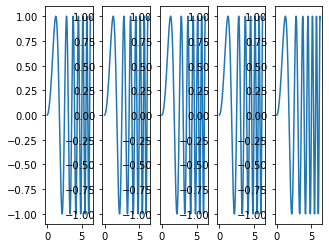

In [16]:
import matplotlib.pyplot as plt
from pylab import *
import numpy as np

x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)


number_of_subplots=5

for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = subplot(1,number_of_subplots+1,v)
    ax1.plot(x,y)

plt.show()

In [81]:
help(subplot)

Help on function subplot in module matplotlib.pyplot:

subplot(*args, **kwargs)
    Add a subplot to the current figure.
    
    Wrapper of `.Figure.add_subplot` with a difference in behavior
    explained in the notes section.
    
    Call signatures::
    
       subplot(nrows, ncols, index, **kwargs)
       subplot(pos, **kwargs)
       subplot(ax)
    
    Parameters
    ----------
    *args
        Either a 3-digit integer or three separate integers
        describing the position of the subplot. If the three
        integers are *nrows*, *ncols*, and *index* in order, the
        subplot will take the *index* position on a grid with *nrows*
        rows and *ncols* columns. *index* starts at 1 in the upper left
        corner and increases to the right.
    
        *pos* is a three digit integer, where the first digit is the
        number of rows, the second the number of columns, and the third
        the index of the subplot. i.e. fig.add_subplot(235) is the same as
       

In [ ]:
L = [(1,2),(3,4)]

for x,y,i in enumerate(L):
    print(x,y)